In [45]:
disconnect()

# Use the code chunk below!

In [41]:
## This code chunk works to make the connection, plot the data in real time, and output the data into LSL


import socket
import time
import pylsl
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
%matplotlib qt
#%matplotlib inline

# SELECT DATA TO STREAM
acc = True      # 3-axis acceleration
bvp = True      # Blood Volume Pulse
gsr = True      # Galvanic Skin Response (Electrodermal Activity)
tmp = True      # Temperature
ibi = True      # Interbeat Interval and Heartbeat
bat = True      # Device Battery
tag = True      # Tag taken from the device (by pressing the button)

serverAddress = '127.0.0.1'
serverPort = 28000
bufferSize = 4096

deviceID = 'CDCB11' # 'A03003'

def connect():
    global s
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.settimeout(3)

    print("Connecting to server")
    s.connect((serverAddress, serverPort))
    print("Connected to server\n")

    print("Devices available:")
    s.send("device_list\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Connecting to device")
    s.send(("device_connect " + deviceID + "\r\n").encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Pausing data receiving")
    s.send("pause ON\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
connect()

time.sleep(1)

def suscribe_to_data():
    if acc:
        print("Suscribing to ACC")
        s.send(("device_subscribe " + 'acc' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bvp:
        print("Suscribing to BVP")
        s.send(("device_subscribe " + 'bvp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if gsr:
        print("Suscribing to GSR")
        s.send(("device_subscribe " + 'gsr' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tmp:
        print("Suscribing to Temp")
        s.send(("device_subscribe " + 'tmp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if ibi:
        print("Suscribing to IBI")
        s.send(("device_subscribe " + 'ibi' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bat:
        print("Suscribing to Batt")
        s.send(("device_subscribe " + 'bat' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tag:
        print("Suscribing to Tag")
        s.send(("device_subscribe " + 'tag' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))

    print("Resuming data receiving")
    s.send("pause OFF\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
suscribe_to_data()

time.sleep(1)

def reconnect():
    print("Reconnecting...")
    connect()
    suscribe_to_data()
    #stream()

def disconnect():
    s.send("device_disconnect\r\n".encode())

def prepare_LSL_streaming():
    #Arguments for pylsl.StreamInfo(NAME, TYPE, CHANNEL_COUNT, NOMINAL_SRATE, CHANNEL_FORMAT, SOURCE_ID)
    print("Starting LSL streaming")
    if acc:
        infoACC = pylsl.StreamInfo('acc','ACC',3,32,'int32','ACC-empatica_e4');
        global outletACC
        outletACC = pylsl.StreamOutlet(infoACC)
    if bvp:
        infoBVP = pylsl.StreamInfo('bvp','BVP',1,64,'float32','BVP-empatica_e4');
        global outletBVP
        outletBVP = pylsl.StreamOutlet(infoBVP)
    if gsr:
        infoGSR = pylsl.StreamInfo('gsr','GSR',1,4,'float32','GSR-empatica_e4');
        global outletGSR
        outletGSR = pylsl.StreamOutlet(infoGSR)
    if tmp:
        infoTemp = pylsl.StreamInfo('tmp','Temp',1,4,'float32','Temp-empatica_e4');
        global outletTemp
        outletTemp = pylsl.StreamOutlet(infoTemp)
    if ibi:
        infoIBI = pylsl.StreamInfo('ibi','IBI',1,0,'float32','IBI-empatica_e4');
        global outletIBI
        outletIBI = pylsl.StreamOutlet(infoIBI)
    if tag:
        infoTag = pylsl.StreamInfo('tag','Tag',1,0,'float32','Tag-empatica_e4');
        global outletTag
        outletTag = pylsl.StreamOutlet(infoTag)
    if bat:
        infoBatt = pylsl.StreamInfo('bat','Batt',1,0,'float32','Batt-empatica_e4');
        global outletBatt
        outletBatt = pylsl.StreamOutlet(infoBatt)
prepare_LSL_streaming()

#global bvp_timestamp
bvp_timestamp = []
#global bvp_data
bvp_data = []
temp_timestamp = []
temp_data = []
acc_timestamp = []
acc_data = []
gsr_timestamp = []
gsr_data = []
#ibi_timestamp = []
#ibi_data = []

plt.style.use('fivethirtyeight')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True)

def animate(i):
    response = s.recv(bufferSize).decode("utf-8")
    #print(response)
    if "connection lost to device" in response:
        print(response.decode("utf-8"))
        reconnect()
    samples = response.split("\n")
    for i in range(len(samples)-1):
        stream_type = samples[i].split()[0]
        if stream_type == "E4_Bvp":
            bvp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
            bvp_new_data = float(samples[i].split()[2].replace(',','.'))
            bvp_timestamp.append(bvp_new_timestamp)
            bvp_data.append(bvp_new_data)
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            outletBVP.push_sample([data], timestamp=timestamp)                        
        if stream_type == "E4_Temperature":
            temp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
            temp_new_data = float(samples[i].split()[2].replace(',','.'))
            temp_timestamp.append(temp_new_timestamp)
            temp_data.append(temp_new_data)
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            outletTemp.push_sample([data], timestamp=timestamp)
        if stream_type == "E4_Acc":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = [int(samples[i].split()[2].replace(',','.')), int(samples[i].split()[3].replace(',','.')), int(samples[i].split()[4].replace(',','.'))]
            acc_timestamp.append(timestamp)
            acc_data.append(data)
            outletACC.push_sample(data, timestamp=timestamp)
        if stream_type == "E4_Gsr":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            gsr_timestamp.append(timestamp)
            gsr_data.append(data)
            outletGSR.push_sample([data], timestamp=timestamp)
        if stream_type == "E4_Ibi":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            #ibi_timestamp.append(timestamp)
            #ibi_data.append(data)
            outletIBI.push_sample([data], timestamp=timestamp)
        if stream_type == "E4_Tag":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            outletTag.push_sample([data], timestamp=timestamp)
        if stream_type == "E4_Battery":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            outletBatt.push_sample([data], timestamp=timestamp)

    ax1.cla()
    ax1.plot([dt.datetime.fromtimestamp(ts) for ts in acc_timestamp], acc_data)
    ax1.set_ylabel('Acc (1/64 g)')
    #ax1.legend(iter(lineObjects), ('X', 'Y', 'Z'), loc='upper left')        
    
    ax2.cla()
    ax2.plot([dt.datetime.fromtimestamp(ts) for ts in bvp_timestamp], bvp_data)
    ax2.set_ylabel('BVP')

    ax3.cla()
    ax3.plot([dt.datetime.fromtimestamp(ts) for ts in gsr_timestamp], gsr_data)
    ax3.set_ylabel('GSR')

    ax4.cla()
    ax4.plot([dt.datetime.fromtimestamp(ts) for ts in temp_timestamp], temp_data)
    ax4.set_ylabel('Temp ($^\circ$C)')
    ax4.set_xlabel('Time')

ani = FuncAnimation(plt.gcf(), animate, interval = 10)

plt.tight_layout
plt.show()

Connecting to server
Connected to server

Devices available:
R device_list 1 | CDCB11 Empatica_E4 

Connecting to device
R device_connect OK

Pausing data receiving
R pause ON

Suscribing to ACC
R device_subscribe acc OK

Suscribing to BVP
R device_subscribe bvp OK

Suscribing to GSR
R device_subscribe gsr OK

Suscribing to Temp
R device_subscribe tmp OK

Suscribing to IBI
R device_subscribe ibi OK

Suscribing to Batt
R device_subscribe bat OK

Suscribing to Tag
R device_subscribe tag OK

Resuming data receiving
R pause OFF

Starting LSL streaming
E4_Acc 1627615446.61715 -11 -11 62
E4_Acc 1627615446.6484 -11 -10 62
E4_Acc 1627615446.67966 -11 -10 62
E4_Acc 1627615446.71091 -11 -11 62
E4_Acc 1627615446.74216 -11 -11 62
E4_Acc 1627615446.77341 -11 -10 63
E4_Bvp 1627615446.64644 -0.6605721
E4_Bvp 1627615446.66206 -0.7392883
E4_Bvp 1627615446.67769 -0.7751312
E4_Bvp 1627615446.69331 -0.7505188
E4_Bvp 1627615446.70894 -0.6791954
E4_Bvp 1627615446.72457 -0.5982628
E4_Bvp 1627615446.74019 -0.

In [51]:
disconnect()

# Testing pulling data from LSL with "StreamInlet"

In [2]:
from pylsl import StreamInlet, resolve_stream

try:
    # first resolve an EEG stream on the lab network
    print("looking for an EEG stream...")
    streams = resolve_stream('type', 'EEG')
    # create a new inlet to read from the stream
    inlet = StreamInlet(streams[0])
    while True:
        # get a new sample (you can also omit the timestamp part if you're not
        # interested in it)
        sample, timestamp = inlet.pull_sample()
        print(timestamp, sample)
except KeyboardInterrupt as e:
    print("Ending program")
    raise e

looking for an EEG stream...


In [46]:
gsr_timestamp[0]

1625592992.661

In [47]:
temp_timestamp[0]

1625592994.02262

In [7]:
disconnect()

In [26]:
print(dt.datetime.fromtimestamp(temp_timestamp[-1]))

2021-07-05 16:22:06.906690


In [4]:
print(response)

E4_Temperature 1625514138.28694 30.43
E4_Temperature 1625514138.53695 30.43
E4_Temperature 1625514138.78696 30.43



In [7]:
0 % 10 == 0

True

In [4]:
max(temp_data)

31.09

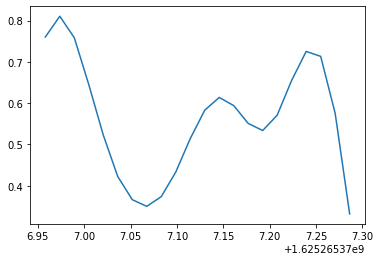

In [3]:
#%matplotlib qt
%matplotlib inline

plt.plot(bvp_timestamp, bvp_data)

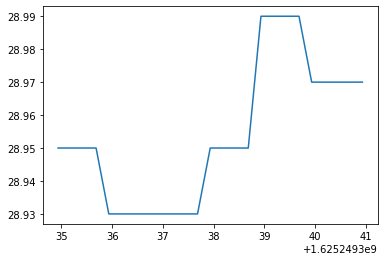

In [19]:
#%matplotlib qt
%matplotlib inline

plt.plot(temp_timestamp, temp_data)

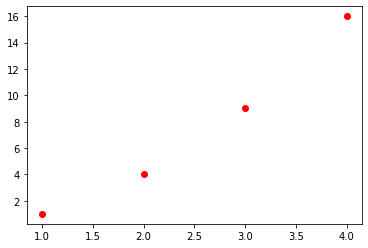

In [46]:
plt.plot([1, 2, 3, 4], [1, 4, 9, 16], 'ro')
plt.show()


In [72]:
%matplotlib qt

plt.figure(2)
plt.subplot()
plt.plot([1,2,3])

In [71]:
%matplotlib qt

plt.figure(1)
plt.subplot()
plt.plot([4,5,6])

In [32]:
plt.cla()

plt.figure(1)                # the first figure
plt.subplot(211)             # the first subplot in the first figure
plt.plot([1, 2, 3])
plt.subplot(212)             # the second subplot in the first figure
plt.plot([4, 5, 6])
plt.show()



In [31]:
plt.clf()

In [10]:
plt.cla

<function matplotlib.pyplot.cla()>

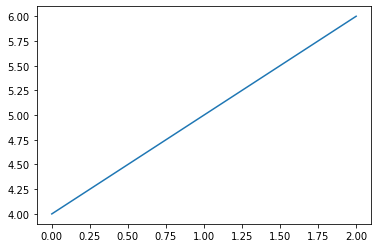

In [61]:
plt.plot([1,2,3])

plt.cla()
plt.plot([4,5,6])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.ion() ## Note this correction
fig=plt.figure()
plt.axis([0,1000,0,1])

i=0
x=list()
y=list()

while i <1000:
    temp_y=np.random.random();
    x.append(i);
    y.append(temp_y);
    plt.scatter(i,temp_y);
    i+=1;
    plt.show()
    plt.pause(0.0001) #Note this correction

In [24]:
from datetime import datetime

test = datetime.fromtimestamp(temp_timestamp[0])
print(test)

2021-07-02 11:25:18.979270


In [ ]:
test2 = []
for i in range(len(temp_timestamp)):
    test2.append(datetime.fromtimestamp(temp_timestamp[i]))



#test2 = datetime.fromtimestamp(temp_timestamp)
print(test2)

In [41]:
print(test2[8])

2021-07-02 11:25:20.979370
